In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
pd.set_option('display.max_rows', None)

In [2]:
sample_file = 'Peneder Sup 1.xlsx'
ctdna_file = 'Peneder Sup 7.xlsx'
dhs_file = 'Peneder Sup 9.xlsx'
sample_df = pd.read_excel(sample_file, 'Patient clinical data', usecols=['Sample','Sample timepoint'])
ctdna_df = pd.read_excel(ctdna_file, 'Genomic ctDNA quantification', usecols=['Sample', 'Combined quantification: % ctDNA'])
dhs_df = pd.read_excel(dhs_file, 'Hematopoietic-specific DHSs', usecols=['Sample', 'Total dip depth'])

In [3]:
df = pd.merge(sample_df, ctdna_df, on='Sample')
df = pd.merge(df, dhs_df, on='Sample')

In [4]:
# relacing ctrl samples' NaN value for 'Sample timepoint'
# removing rows with values that can't evaluated
df.loc[190:211, 'Sample timepoint'] = 'control'
df = df.dropna()
df = df[df['Combined quantification: % ctDNA'] != 'nonsensical output']
df.reset_index(drop=True, inplace=True)
df['Combined quantification: % ctDNA'] = df['Combined quantification: % ctDNA'].infer_objects()

In [5]:
conditions = [(df['Sample timepoint'] == 'control'),
              (df['Sample timepoint'] == 'diagnosis') & (df['Combined quantification: % ctDNA'] == 0),
             (df['Sample timepoint'] == 'diagnosis') & (df['Combined quantification: % ctDNA'] != 0),
             (df['Sample timepoint'] == 'therapy') & (df['Combined quantification: % ctDNA'] == 0),
             (df['Sample timepoint'] == 'therapy') & (df['Combined quantification: % ctDNA'] != 0),
             (df['Sample timepoint'] == 'relapse') & (df['Combined quantification: % ctDNA'] == 0),
             (df['Sample timepoint'] == 'relapse') & (df['Combined quantification: % ctDNA'] != 0),
             (df['Sample timepoint'] == 'remission') & (df['Combined quantification: % ctDNA'] == 0),
             (df['Sample timepoint'] == 'remission') & (df['Combined quantification: % ctDNA'] != 0)]
values = [True, False, True, False, True, False, True, False, True]
df['category'] = np.select(conditions, values)

In [6]:
dark2_colors = sns.color_palette('Dark2').as_hex()
tp_colors = [dark2_colors[1], dark2_colors[2],dark2_colors[0], dark2_colors[3], dark2_colors[-1]]

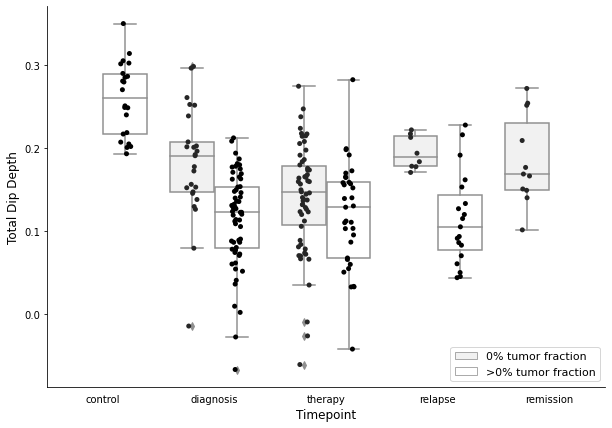

In [18]:
plt.rcParams['figure.figsize'] = (10,7)
ax = sns.boxplot(x='Sample timepoint', y='Total dip depth',  hue='category', data=df, 
           order = ['control', 'diagnosis', 'therapy', 'relapse', 'remission'], color='white')

sns.stripplot(x="Sample timepoint", y="Total dip depth", data=df,
              hue='category', color='black', order = ['control', 'diagnosis', 'therapy', 'relapse', 'remission'],
              dodge=True, ax=ax)
plt.ylabel('Total Dip Depth', fontsize=12)
plt.xlabel('Timepoint', fontsize=12)
plt.legend(loc='lower right', labels=['0% tumor fraction', '>0% tumor fraction'], prop={'size': 11})
ax.tick_params(bottom=False)
sns.despine() 
#plt.savefig(f'peneder_box.png',dpi=300)

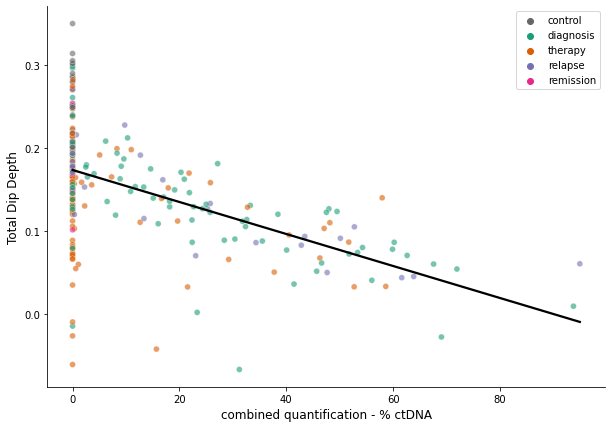

In [8]:
plt.rcParams['figure.figsize'] = (10,7)
ax = sns.scatterplot(x='Combined quantification: % ctDNA', 
                y='Total dip depth', hue='Sample timepoint',data=df,
               palette = tp_colors, alpha=0.6)
sns.regplot(ax=ax, x='Combined quantification: % ctDNA', 
                y='Total dip depth', ci=None, scatter=False,data=df, color='black')
plt.ylabel('Total Dip Depth', fontsize=12)
plt.xlabel('combined quantification - % ctDNA', fontsize=12)
plt.legend(prop={'size': 13})

handler, label = ax.get_legend_handles_labels()
label[0], label[1], label[2], label[3], label[4] = label[4], label[2], label[0], label[1], label[3]
handler[0], handler[1], handler[2], handler[3], handler[4] = handler[4], handler[2], handler[0], handler[1], handler[3]
ax.legend(handler, label)
sns.despine() 
#plt.savefig(f'pender_corr.png',dpi=300)

In [9]:
df.loc[:,'Combined quantification: % ctDNA'].corr(df.loc[:, 'Total dip depth'])

-0.5367410455580699

In [10]:
diag_df = df.query('`Sample timepoint` == "diagnosis"')
diag_df.loc[:,'Combined quantification: % ctDNA'].corr(diag_df.loc[:, 'Total dip depth'])

-0.6822015790339118

In [11]:
condition_depths = []
for i in range(len(conditions)):
    condition_depth = []
    for j in range(len(conditions[i])):
        if conditions[i][j] == True:
            condition_depth.append(df['Total dip depth'].iloc[j])
    condition_depths.append(condition_depth)

In [12]:
tumor_fractions = []
for i in range(len(conditions)):
    tumor_fraction = []
    for j in range(len(conditions[i])):
        if conditions[i][j] == True:
            tumor_fraction.append(df['Combined quantification: % ctDNA'].iloc[j])
    tumor_fractions.append(tumor_fraction)

In [23]:
mann_whit_u = []
for i in range(len(condition_depths[1:-1])):
    stat, p = stats.mannwhitneyu(condition_depths[0], condition_depths[i+1], alternative='greater')
    
    d_first_centile = np.quantile(condition_depths[i+1], 0.25)
    d_median = np.quantile(condition_depths[i+1], 0.5)
    d_third_centile = np.quantile(condition_depths[i+1], 0.75)
    
    tf_first_centile = np.quantile(tumor_fractions[i+1], 0.25)
    tf_median = np.quantile(tumor_fractions[i+1], 0.5)
    tf_third_centile = np.quantile(tumor_fractions[i+1], 0.75)
    
    number_of_tests = len(condition_depths[1:-1])
    n = len(condition_depths[i+1])
    mann_whit_u.append([stat, p, p * number_of_tests, 
                        d_first_centile, d_median, d_third_centile, 
                        tf_first_centile, tf_median, tf_third_centile])

In [27]:
# there were no remission samples with tumor fraction >0%
mann_df = pd.DataFrame(mann_whit_u, columns = ['U', 'p-value', 'adjusted p-value', 
                                               'depth_25th_centile', 'depth_median', 'depth_75th_centile',
                                               'tf_25th_centile', 'tf_median', 'tf_75th_centile'])
mann_df['timepoint - % ctDNA'] = ['diagnosis - =0%', 'diagnosis - >0%', 'therapy - =0%', 'therapy - >0%',
                             'relapse - =0%', 'relapse - >0%', 'remission - =0%']
mann_df = mann_df.set_index('timepoint - % ctDNA')
mann_df

,U,p-value,adjusted p-value,depth_25th_centile,depth_median,depth_75th_centile,tf_25th_centile,tf_median,tf_75th_centile
timepoint - % ctDNA,,,,,,,,,
diagnosis - =0%,463.0,3.200568e-05,2.240398e-04,0.147351,0.190905,0.207512,0.000000,0.000000,0.000000
diagnosis - >0%,1309.0,5.726480e-12,4.008536e-11,0.079849,0.123265,0.153290,14.281705,24.651667,45.903869
therapy - =0%,1210.0,3.683690e-10,2.578583e-09,0.107471,0.146784,0.178774,0.000000,0.000000,0.000000
therapy - >0%,710.0,1.316836e-09,9.217850e-09,0.067745,0.128887,0.158873,2.267942,16.640000,37.724270
relapse - =0%,157.0,2.844731e-04,1.991312e-03,0.178132,0.188811,0.214039,0.000000,0.000000,0.000000
relapse - >0%,406.0,1.393090e-07,9.751631e-07,0.076806,0.105269,0.143274,13.025000,25.758474,48.859248
remission - =0%,203.0,9.277363e-04,6.494154e-03,0.150039,0.168856,0.230413,0.000000,0.000000,0.000000
